## Quantum Split Federated Learning using Pennylane (2-Class)

## Basic Libraries

In [31]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

## Define dataset to train

Number of classes: 2
Class distribution: [100 100]


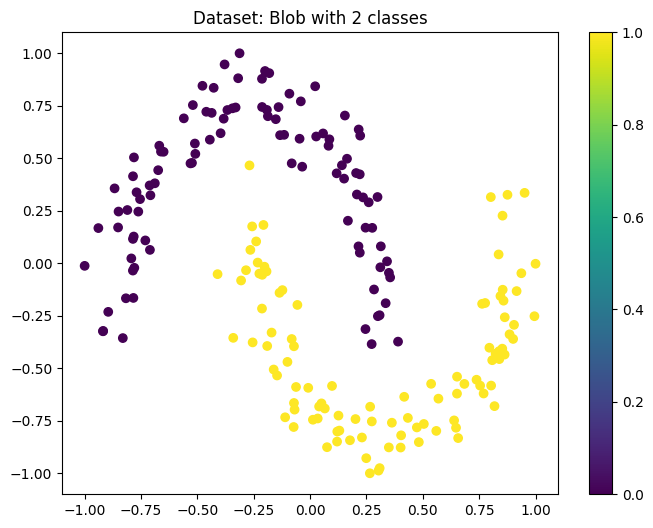

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import torch

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

n_s = 200
n_client = 1

X, y = make_moons(n_samples=n_s * n_client, noise=0.1)

print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

# y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
# y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

plt.figure(figsize=(8, 6))

# 데이터 정규화 (~np.pi, np.pi범위로 변경)
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) * 2 - 1
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter)
plt.title(f"Dataset: Blob with {len(np.unique(y))} classes")
plt.show()

## Labeling
- 퀀텀 특성 살려서

In [33]:
def quantum_onehot_2(y):
    """
    y 가 batch 형태로 들어오게 되면...
    0 -> -1, 1-> 1로 변경
    """
    return np.where(y == 0, -1, y).reshape(-1, 1) # 양자 상태다 보니 아무래도 -1이 학습하기가 더 쉽다~

y = y.reshape(-1, 1)

def onehot_to_class_2(y_onehot):
    """
    y_onehot 가 batch 형태로 들어오게 되면...
    """
    y_class = np.zeros((len(y_onehot),))

    for i, y_ in enumerate(y_onehot):
        y_class[i] = int(y_[0] * 2 + y_[1])

    return y_class

## Splitting the dataset, varying IIDness

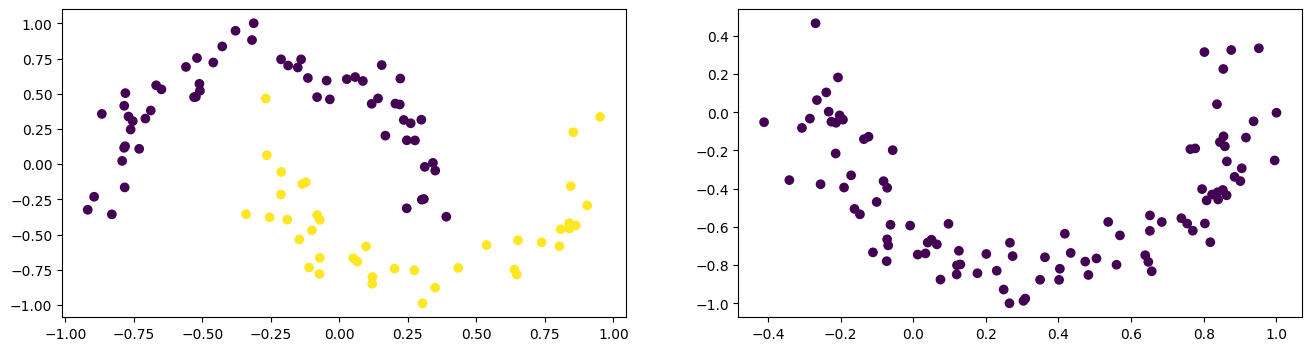

In [36]:
from torch.distributions import Dirichlet

def split_dataset(datas, labels, n_clients, n_classes, dataset_size=100, alpha=0.1):
    '''
    split the dataset according to the dirichlet distribution
    data and label should be batched
    '''
    dist = Dirichlet(torch.tensor([alpha] * n_classes))

    split_datas = []
    split_labels = []

    organized_classes = [[] for _ in range(n_classes)]

    # organize the original dataset
    data_tmp = []
    label_tmp = []

    for idx in range(len(datas)):
        organized_classes[labels[idx]].append(datas[idx])

    for _ in range(n_clients):
        # sample the distribution
        p = dist.sample()

        data_tmp.clear()
        label_tmp.clear()

        # assign data to clients according to the sampled distribution
        for j in range(n_classes):
            n_samples = int(p[j] * dataset_size)
            data_tmp.extend(organized_classes[j][:n_samples])
            label_tmp.extend([j] * n_samples)

        split_labels.append(np.stack(label_tmp))
        split_datas.append(np.stack(data_tmp))

    return split_datas, split_labels

split_x, split_y = split_dataset(X, y.reshape(-1,), n_clients=2, n_classes=2, alpha=0.5)

fig = plt.figure(figsize=(16, 4))
for i in range(2):
    fig.add_subplot(1, 2, i+1)
    plt.scatter(split_x[i][:, 0], split_x[i][:, 1], c=split_y[i], cmap='viridis', label=f'Client {i+1}')

plt.show()


## Define module to train

Circuit visualization:
(<Figure size 1100x300 with 1 Axes>, <Axes: >)


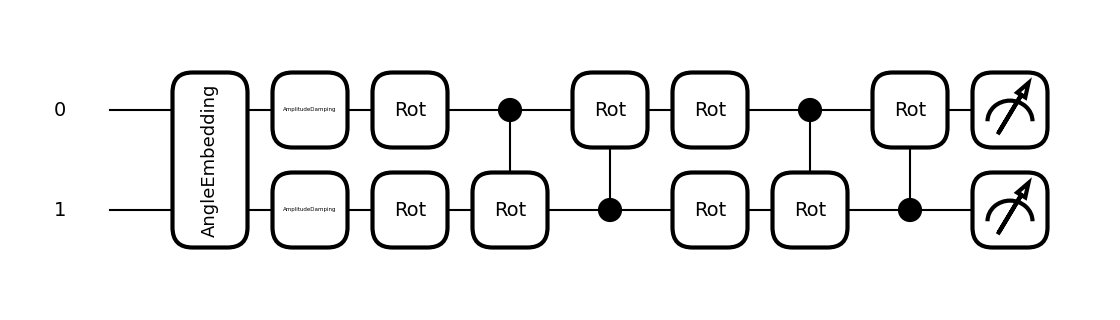

In [ ]:
n_qubits = 2
dev = qml.device("default.mixed", wires=n_qubits)


def encoding_layer(inputs):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

def entangle_layer(weights):
    # per layer
    for layer_param in weights:
        qml.Rot(*layer_param[0:3], wires=0)
        qml.Rot(*layer_param[3:6], wires=1)
        qml.CRot(*layer_param[6:9], wires=[0, 1])
        qml.CRot(*layer_param[9:12], wires=[1, 0])

def quantum_channel(level, type, wire_num):
    if type == 'phase_damping':
        qml.PhaseDamping(level, wires=wire_num)
    elif type == 'amplitude_damping':
        qml.AmplitudeDamping(level, wires=wire_num)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    entangle_layer(weights)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode_with_noise2(inputs, weights):

    noise_prob = 0.0
    cut_layer = 0

    # define function inside a function to avoid global variables
    def encoding_layer_with_noise(inputs):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        for i in range(n_qubits):
            quantum_channel(noise_prob, 'amplitude_damping', i)
            # Add noise to the encoding layer

    def entangle_layer_with_noise(weights):
        # per layer

        assert len(weights) > cut_layer, "cut_layer must be less than the total number of layers"

        for i, layer_param in enumerate(weights):
            if (i < cut_layer): # client side, adding noise
                qml.Rot(*layer_param[0:3], wires=0)
                qml.PhaseDamping(noise_prob, wires=0)
                qml.Rot(*layer_param[3:6], wires=1)
                qml.PhaseDamping(noise_prob, wires=1)
                qml.CRot(*layer_param[6:9], wires=[0, 1])
                qml.PhaseDamping(noise_prob, wires=0)
                qml.PhaseDamping(noise_prob, wires=1)
                qml.CRot(*layer_param[9:12], wires=[1, 0])
                qml.PhaseDamping(noise_prob, wires=0)
                qml.PhaseDamping(noise_prob, wires=1)
            else: # server side, no noise
                qml.Rot(*layer_param[0:3], wires=0)
                qml.Rot(*layer_param[3:6], wires=1)
                qml.CRot(*layer_param[6:9], wires=[0, 1])
                qml.CRot(*layer_param[9:12], wires=[1, 0])

    encoding_layer_with_noise(inputs)
    entangle_layer_with_noise(weights)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layer = 2
weight_shapes = {"weights": (n_layer, 12)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# 예시회로 출력하기
print("Circuit visualization:")
dummy_inputs = np.array([0.5, 0.3]).reshape(-1, 2)  # 더미 입력값
dummy_weights = np.random.random((n_layer, 12))  # 더미 가중치
print(qml.draw_mpl(qnode_with_noise2, show_all_wires=True)(dummy_inputs, dummy_weights))

## 4 qubit module

In [ ]:
n_qubits = 4
dev = qml.device("default.mixed", wires=n_qubits)

def encoding_layer(inputs):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

def entangle_layer(weights):
    # per layer
    for layer_param in weights:
        qml.Rot(*layer_param[0:3], wires=0)
        qml.Rot(*layer_param[3:6], wires=1)
        qml.CRot(*layer_param[6:9], wires=[0, 1])
        qml.CRot(*layer_param[9:12], wires=[1, 0])

def quantum_channel(level, type, wire_num):
    if type == 'phase_damping':
        qml.PhaseDamping(level, wires=wire_num)
    elif type == 'amplitude_damping':
        qml.AmplitudeDamping(level, wires=wire_num)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    entangle_layer(weights)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode_with_noise4(inputs, weights):

    noise_prob = 0.0
    cut_layer = 0

    # define function inside a function to avoid global variables
    def encoding_layer_with_noise(inputs):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        for i in range(n_qubits):
            quantum_channel(noise_prob, 'amplitude_damping', i)
            # Add noise to the encoding layer

    def entangle_layer_with_noise(weights):
        # per layer

        assert len(weights) > cut_layer, "cut_layer must be less than the total number of layers"

        for i, layer_param in enumerate(weights):
            if (i < cut_layer): # client side, adding noise
                qml.Rot(*layer_param[0:3], wires=0)
                qml.PhaseDamping(noise_prob, wires=0)
                qml.Rot(*layer_param[3:6], wires=1)
                qml.PhaseDamping(noise_prob, wires=1)
                qml.CRot(*layer_param[6:9], wires=[0, 1])
                qml.PhaseDamping(noise_prob, wires=0)
                qml.PhaseDamping(noise_prob, wires=1)
                qml.CRot(*layer_param[9:12], wires=[1, 0])
                qml.PhaseDamping(noise_prob, wires=0)
                qml.PhaseDamping(noise_prob, wires=1)
            else: # server side, no noise
                qml.Rot(*layer_param[0:3], wires=0)
                qml.Rot(*layer_param[3:6], wires=1)
                qml.CRot(*layer_param[6:9], wires=[0, 1])
                qml.CRot(*layer_param[9:12], wires=[1, 0])

    encoding_layer_with_noise(inputs)
    entangle_layer_with_noise(weights)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layer = 2
weight_shapes = {"weights": (n_layer, 12)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# 예시회로 출력하기
print("Circuit visualization:")
dummy_inputs = np.array([0.5, 0.3, 0.2, 0.1]).reshape(-1, 4)  # 더미 입력값
dummy_weights = np.random.random((n_layer, 12))  # 더미 가중치
print(qml.draw_mpl(qnode_with_noise4, show_all_wires=True)(dummy_inputs, dummy_weights))

In [38]:
def train_evaluate(model):
    with torch.no_grad():
        model.eval()

        # Test on the entire dataset
        test_data = torch.tensor(X).to("cuda").float()
        test_labels = torch.tensor(y).reshape(-1, 1).to("cuda")
        
        # Get predictions
        predictions = model(test_data)

        # 첫 번째 큐비트의 값만 사용할 것임
        predictions = predictions[:, 0].reshape(-1, 1).to("cuda")
        
        # Convert to class predictions 
        # prediction 은 -1부터 1 범위인데 이걸 round하면 그냥 이상해짐
        # 0~1 사이의 범위로 변환 후 round
        predicted_classes = torch.round(0.5 * predictions + 0.5).long()
        
        # Calculate accuracy
        correct = (predicted_classes == test_labels).sum().item()
        total = test_labels.size(0)
        print(f"Test Accuracy: {(correct / total) * 100:.2f}%")

        return correct/total


## Test (Training, 1-client)

In [11]:
from tqdm import tqdm

n_layer = 2
weight_shapes = {"weights": (n_layer, 12)}
classifier = qml.qnn.TorchLayer(qnode_with_noise, weight_shapes).to("cuda")
optimizer = torch.optim.Adam(classifier.parameters())

train_loader = DataLoader(list(zip(X, y)), batch_size=32, shuffle=False)

# 데이터셋의 클래스 개수 확인
n_classes = len(np.unique(y))
print(f"Number of classes: {n_classes}")
num_eval = 10

loss_fn = nn.MSELoss()

for i in tqdm(range(150)):
    
    mean_loss = 0

    for data, label in train_loader:

        data = data.to("cuda").float()
        label = quantum_onehot_2(label)
        label = torch.from_numpy(label).to("cuda").float()
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = classifier(data)  # Shape: [batch_size, n_qubits]

        # 첫 번째 큐비트의 값만 사용 (BP 방지)
        loss = loss_fn(outputs[:,0].reshape(-1, 1), label)
        mean_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

    if (i + 1) % num_eval == 0:
        print(f"Epoch {i+1}, Loss: {mean_loss / len(train_loader):.4f}")
        accuracy = train_evaluate(classifier)
        

Number of classes: 2


  6%|▌         | 9/150 [01:15<19:29,  8.30s/it]

Epoch 10, Loss: 0.8818


  7%|▋         | 10/150 [01:27<22:21,  9.58s/it]

Test Accuracy: 71.00%


 13%|█▎        | 19/150 [02:42<18:16,  8.37s/it]

Epoch 20, Loss: 0.7377


 13%|█▎        | 20/150 [02:54<20:50,  9.62s/it]

Test Accuracy: 71.50%


 19%|█▉        | 29/150 [04:11<17:22,  8.61s/it]

Epoch 30, Loss: 0.6470


 20%|██        | 30/150 [04:24<19:46,  9.89s/it]

Test Accuracy: 76.00%


 21%|██        | 31/150 [04:39<17:52,  9.01s/it]


KeyboardInterrupt: 

## Interence

Test Accuracy: 77.00%


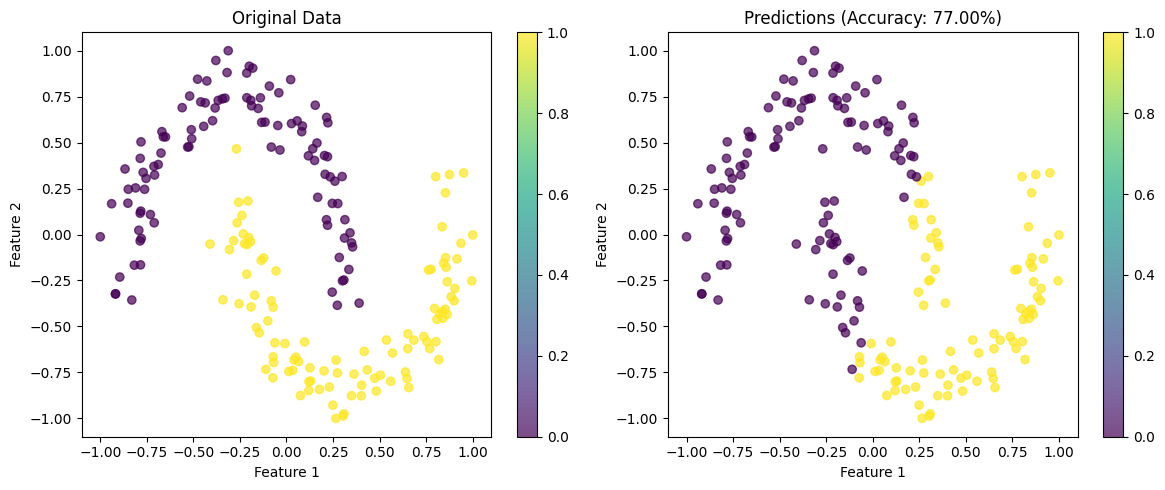

In [12]:
# Testing the trained model

with torch.no_grad():
    classifier.eval()  # Set model to evaluation mode
    
    # Test on the entire dataset
    test_data = torch.tensor(X).to("cuda").float()
    test_labels = torch.tensor(y).to("cuda")
    
    # Get predictions
    predictions = classifier(test_data)[:, 0].reshape(-1, 1).to("cuda")
    
    # Convert to class predictions 
    predicted_classes = torch.round(0.5 * predictions + 0.5).long()
    
    # Calculate accuracy
    accuracy = (predicted_classes == test_labels).float().mean()
    print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")
    
    # Visualize predictions
    plt.figure(figsize=(12, 5))
    
    # Original data
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("Original Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    # Predictions
    plt.subplot(1, 2, 2)
    predicted_np = predicted_classes
    scatter = plt.scatter(X[:, 0], X[:, 1], c=np.array(predicted_np.cpu()), cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f"Predictions (Accuracy: {accuracy.item() * 100:.2f}%)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    plt.tight_layout()
    plt.show()
    
    # Confusion matrix for multi-class
    if len(np.unique(y)) > 2:
        from sklearn.metrics import confusion_matrix, classification_report
        import seaborn as sns
        
        cm = confusion_matrix(test_labels.cpu().numpy(), predicted_np)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        print("\nClassification Report:")
        print(classification_report(test_labels.cpu().numpy(), predicted_np))